In [1]:
from riskyneuroarousal.modeling.behavioral_models import (get_trials, 
                                                    simulate_behavior, 
                                                    negLL_EV_binary, 
                                                    negLL_EV_ordinal, 
                                                    negLL_CPT_binary,
                                                    negLL_CPT_ordinal,
                                                    fit_model)
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
models_test = ["EV_binary", "EV_ordinal", 
               "CPT_binary_history", "CPT_ordinal_history",]

In [41]:
parameter_ranges = {"lambd" : [1.5],
                    "alpha" : [0.9, 1.2],
                    "c" : [0.5, 1.5],
                    "sigma" : [1.5, 3.5, 5.5, 7.5],
                    "a_1" : [2],
                    "a_2" : [-2],
                    "delta" : [1],}

In [22]:
model_params_info = {
    "EV_binary" : {
        "negLL": negLL_EV_binary,
        "bounds": ((-10, 10), (0.1, 6), (0, 0)),
        "pars0": [-1, 1, 0],
        "param_names": ["c", "sigma", "delta", "LL"],
    }, 
    "EV_ordinal" : {
        "negLL": negLL_EV_ordinal,
        "bounds": ((0, 10), (-10, 0), (-10, 10), (0.1, 6), (0, 0)),
        "pars0": [2, -2, 1, 1, 0],
        "param_names": ["a_1", "a_2", "c", "sigma", "delta", "LL"],
    },
    "CPT_binary_history" : {
        "negLL": negLL_CPT_binary,
        "bounds": ((0.1, 2), (0, 5), (-10, 10), (0.1, 6), (-2, 2)),
        "pars0": [0.9, 1.5, 1, 1, 0],
        "param_names": ["alpha", "lambd", "c", "sigma", "delta", "LL"],
    },
    "CPT_ordinal_history" : {
        "negLL": negLL_CPT_ordinal,
        "bounds": ((0.1, 2), (0, 5), (0, 10), (-10, 0), (-10, 10), (0.1, 6), (-2, 2)),
        "pars0": [0.9, 1, 10, -2, 0.5, 1, 0],
        "param_names": ["alpha", "lambd", "a_1", "a_2", "c", "sigma", "delta", "LL"],
    },
}

In [47]:
params_test = list(itertools.product(*parameter_ranges.values()))
params_test = pd.DataFrame(params_test, columns=parameter_ranges.keys())
params_test["indx"] = params_test.index

In [ ]:
param_combinations[model_params + ['indx']].drop_duplicates(subset=model_params, keep='last')

In [49]:
x = params_test[["c", "sigma", "delta"] + ["indx"]].drop_duplicates(subset=["c", "sigma", "delta"], keep='last')

In [60]:
for i in range(0, 10, 100):
    print(i)

0


In [63]:
p["delta"] = 0

/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_34296/3597303764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p["delta"] = 0


In [64]:
p

c        0.5
sigma    1.5
delta    0.0
indx     8.0
Name: 8, dtype: float64

In [4]:
gains = np.arange(10, 41, 2)
losses = np.arange(5, 21, 1)
trials = get_trials(gains, losses, repetitions = 1)

In [ ]:
param_names,estimates,real,indx,model,condition
alpha,0.6298091008057497,0.4,0.0,CPT_binary_history,equalIndifference
lambd,0.0,0.8,0.0,CPT_binary_history,equalIndifference
c,-10.0,-2.5,0.0,CPT_binary_history,equalIndifference
sigma,2.893116263319694,0.5,0.0,CPT_binary_history,equalIndifference
delta,3.0,-1.5,0.0,CPT_binary_history,equalIndifference
loss,2.560000211943349e-08,,0.0,CPT_binary_history,equalIndifference


In [40]:
curr_params = {
    "alpha": 0.7,
    "lambd": 0.8,
    "c": -1,
    "sigma": 0.5,
    "a_1": 3,
    "a_2": -3,
    "delta": -1.5,
}

trials = simulate_behavior(trials, curr_params, model = "CPT_binary")

In [43]:
trials["accept"].mean() > 0.9

np.True_

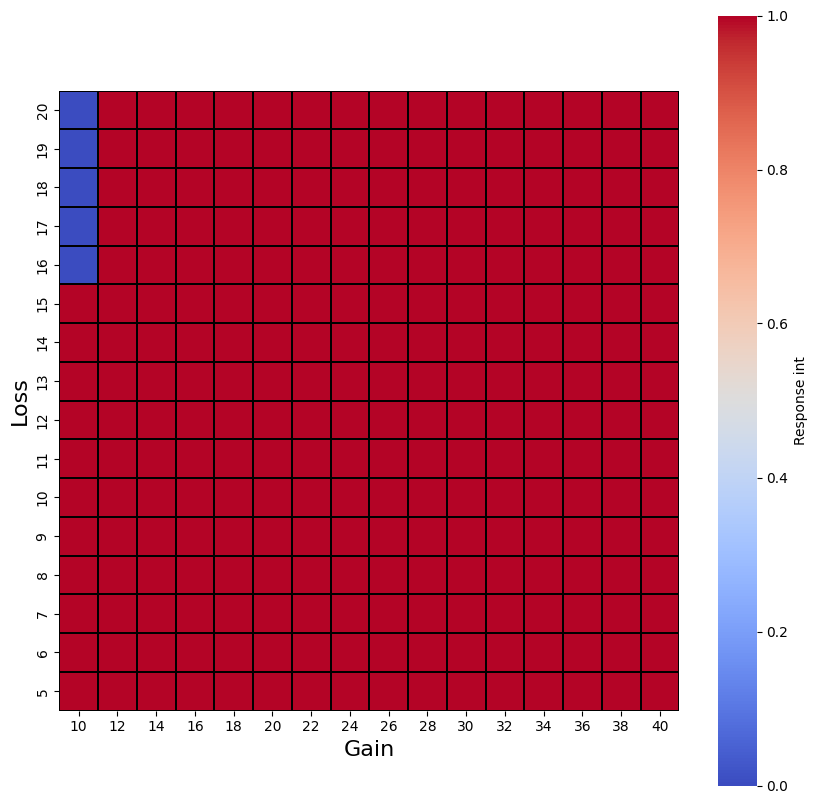

In [41]:
plt.figure(figsize=(10, 10))
hmap_data = trials.groupby(['loss', 'gain'])['response_int'].mean().unstack()
# Reverse the order of gain
hmap_data = hmap_data.iloc[::-1]
sns.heatmap(hmap_data, cmap='coolwarm', cbar_kws={'label': 'Response int'}, square=True, linewidths=0.2, linecolor='black', cbar = True)
plt.xlabel("Gain", fontsize=16)
plt.ylabel("Loss", fontsize=16)
# Increase font size of labels and ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [25]:
test_models = ["CPT_binary_history", "CPT_ordinal_history"]
model_params = {model_name : {"param_names" : [], 
                              "estimates" : [], 
                              "indx" : [], 
                              "condition" : []
                              }
                for model_name in test_models}

In [26]:
for indx in range(len(params_test)):
    # Simulate behavior
    trials = simulate_behavior(trials_equalRange, params_test.iloc[indx], model = test_models[0])
    trials['history'] = trials['accept'].shift(1).fillna(0).astype(int)
    trials = trials.reset_index(drop=True)
    # Fit model
    for m in test_models:
        pars, loss = fit_model(trials, 
                            model_params_info[m]["negLL"], 
                            pars0 = model_params_info[m]["pars0"],
                            bounds = model_params_info[m]["bounds"], 
        )
        if pars is not None:
            model_params[m]["param_names"].extend(model_params_info[m]["param_names"])
            model_params[m]["estimates"].extend(pars)
            model_params[m]["estimates"].extend([loss])
            model_params[m]["indx"].extend([indx] * len(model_params_info[m]["param_names"]))
            model_params[m]["condition"].extend(["equalRange"] * len(model_params_info[m]["param_names"]))
            print(f"Row {indx} fitted successfully!")


/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_34296/4078281163.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['history'] = trials['accept'].shift(1).fillna(0).astype(int)


[0.9, 1.5, 1, 1, 0]
Row 0 fitted successfully!
[0.9, 1, 10, -2, 0.5, 1, 0]
Row 0 fitted successfully!
[0.9, 1.5, 1, 1, 0]


/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_34296/4078281163.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['history'] = trials['accept'].shift(1).fillna(0).astype(int)


Row 1 fitted successfully!
[0.9, 1, 10, -2, 0.5, 1, 0]
Row 1 fitted successfully!
[0.9, 1.5, 1, 1, 0]


/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_34296/4078281163.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['history'] = trials['accept'].shift(1).fillna(0).astype(int)


Row 2 fitted successfully!
[0.9, 1, 10, -2, 0.5, 1, 0]
Row 2 fitted successfully!
[0.9, 1.5, 1, 1, 0]


/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_34296/4078281163.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['history'] = trials['accept'].shift(1).fillna(0).astype(int)


KeyboardInterrupt: 

In [28]:
for m in test_models:
    model_params[m] = pd.DataFrame(model_params[m])

In [29]:
# Combine all model parameters into a single DataFrame
model_params = pd.concat(
    [df.assign(model=name) for name, df in model_params.items()],
    ignore_index=True
)

<Axes: xlabel='indx', ylabel='estimates'>

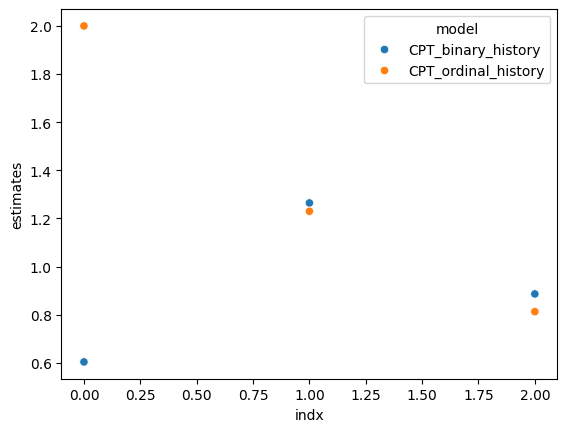

In [35]:
sns.scatterplot(data=model_params.query("param_names == 'delta'"), x="indx", y="estimates", hue="model")

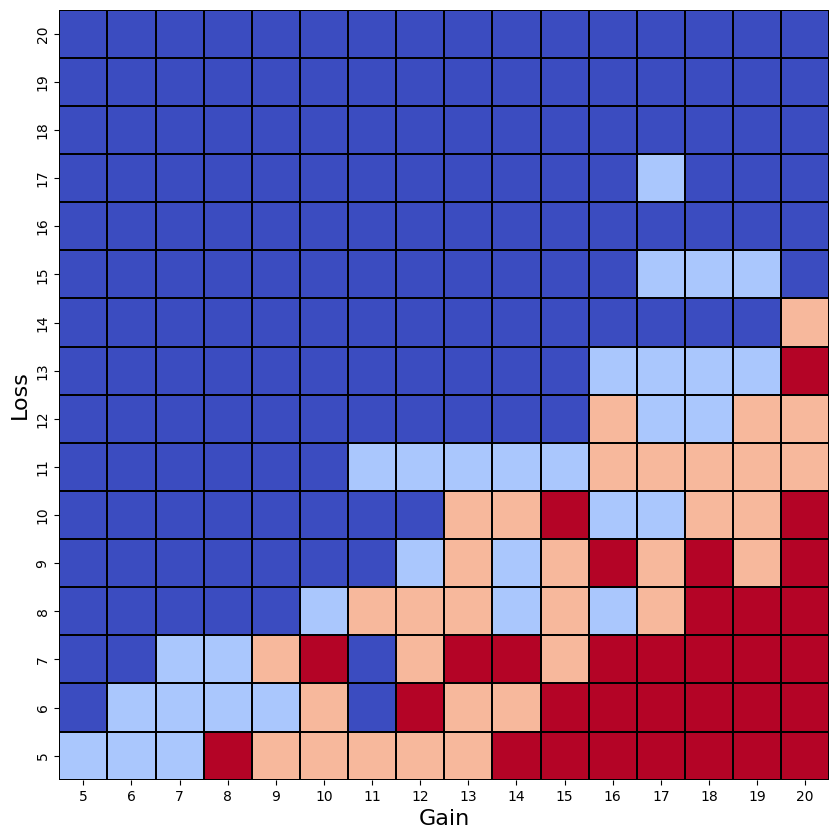